# Train a model on the crunchy-snow dataset

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import crunchy_snow.models
import crunchy_snow.dataset

## Prepare dataloader

In [2]:
# get paths to data
train_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v2/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v2/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
# to test code with a small sample of the data
import random
n_imgs = 16

train_path_list = random.sample(train_path_list, n_imgs )
val_path_list = random.sample(val_path_list, n_imgs)

In [4]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = crunchy_snow.dataset.Dataset(train_path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

In [5]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr']

## Train model

In [6]:
# import model
# model = crunchy_snow.models.SimpleCNN(n_input_channels=len(input_channels))
# model = crunchy_snow.models.UNet(n_input_channels=len(input_channels))
# model = crunchy_snow.models.ResUNet(n_input_channels=len(input_channels))
# model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
# model = crunchy_snow.models.VisionTransformer(n_input_channels=len(input_channels))

model = crunchy_snow.models.SimpleCNN(n_input_channels=len(input_channels))
model.to('cuda');  # Run on GPU

# name your model
model_name = 'janedoe_SimpleCNN_v0'

In [7]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.0003)
loss_fn = nn.MSELoss()
epochs = 50

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    epoch_loss = []
    val_temp_loss = []

    # Loop through training data
    for data_tuple in train_loader:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = torch.clamp(model(inputs), 0, 1)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        epoch_loss.append(loss.item())

        loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(epoch_loss))
    print(f'Training loss: {np.mean(epoch_loss)}')

    # Run model on validation data
    for data_tuple in val_loader:
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = torch.clamp(model(inputs), 0, 1)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_temp_loss.append(loss.item())

    val_loss.append(np.mean(val_temp_loss))
    print(f'Validation loss: {np.mean(val_temp_loss)}')
    
    # # save model
    # torch.save(model.state_dict(), f'../../weights/{model_name}')

    # # save loss 
    # with open(f'../../loss/{model_name}_val_loss.pkl', 'wb') as f:
    #     pickle.dump(val_loss, f)
        
    # with open(f'../../loss/{model_name}_train_loss.pkl', 'wb') as f:
    #     pickle.dump(train_loss, f)


Starting epoch 1
Training loss: 0.001398368738591671
Validation loss: 0.0007274139299964233

Starting epoch 2
Training loss: 0.000992544461041689
Validation loss: 0.0007761946664626151

Starting epoch 3
Training loss: 0.0009960095630958676
Validation loss: 0.0007816766742774206

Starting epoch 4
Training loss: 0.0009804003639146686
Validation loss: 0.0007011314677818348

Starting epoch 5
Training loss: 0.0008850715821608901
Validation loss: 0.0006686034373908356

Starting epoch 6
Training loss: 0.0008527496247552335
Validation loss: 0.0006586288183827449

Starting epoch 7
Training loss: 0.0008366665570065379
Validation loss: 0.0006353788373916203

Starting epoch 8
Training loss: 0.0007883181096985936
Validation loss: 0.0006167509406571625

Starting epoch 9
Training loss: 0.0007337619317695498
Validation loss: 0.0006305787839897548

Starting epoch 10
Training loss: 0.0007154186605475843
Validation loss: 0.0006274884393357993

Starting epoch 11
Training loss: 0.0006953052943572402
Valid

## Examine results

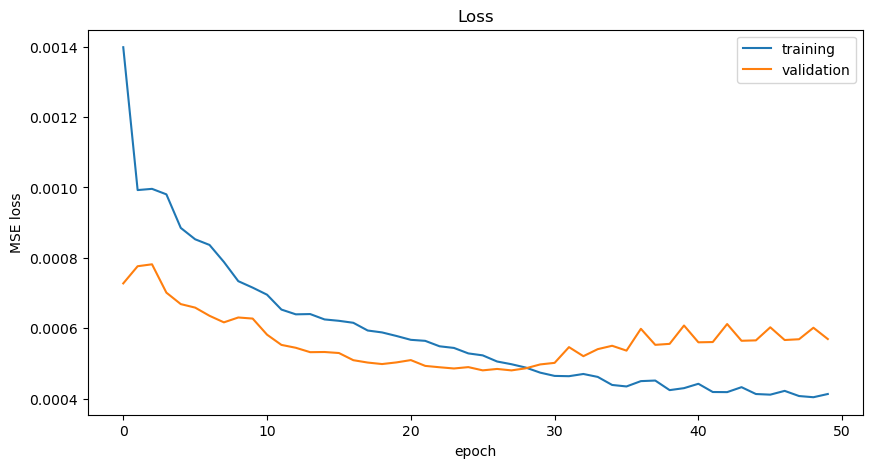

In [8]:
# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
# plt.savefig(f'../../figs/{model_name}_loss.png', dpi=300)

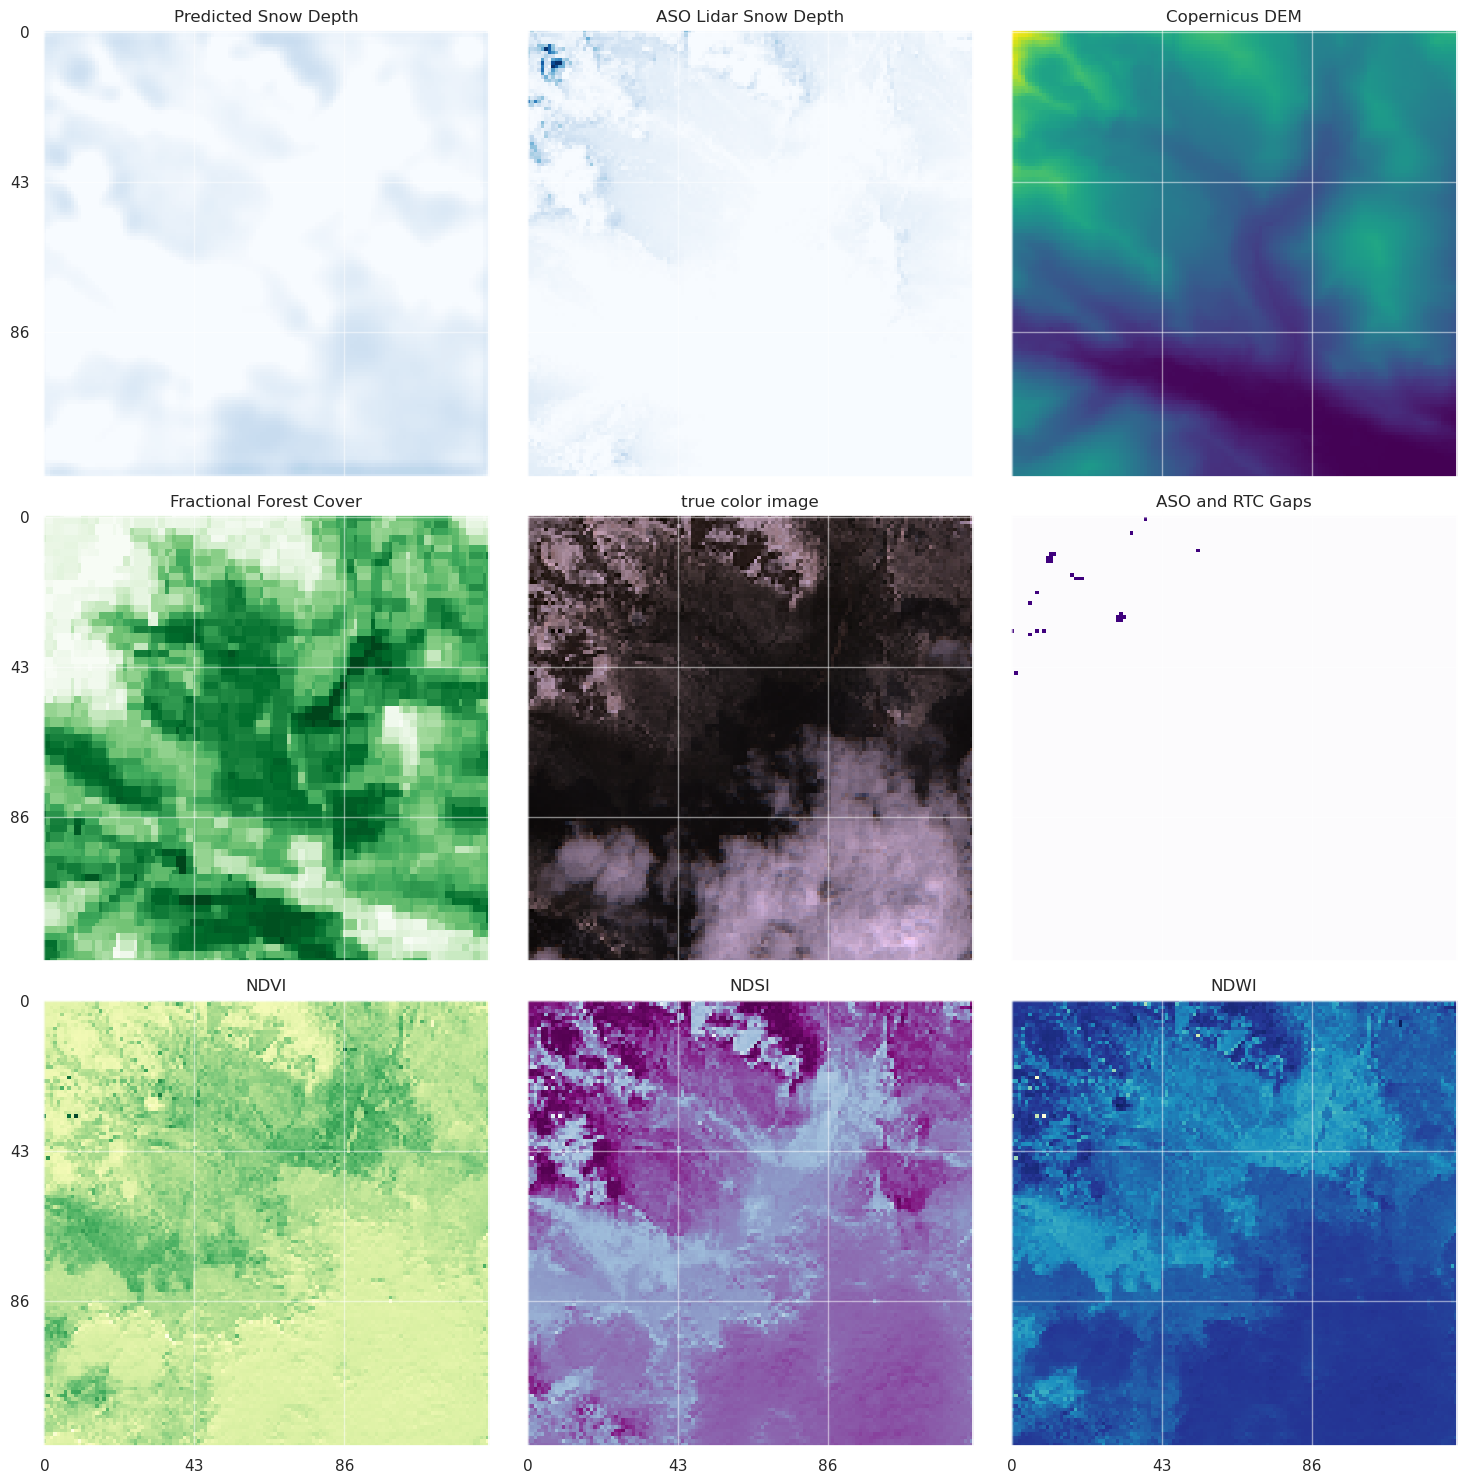

In [9]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze() + data_dict['s2_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        f.tight_layout()
    else:
        break


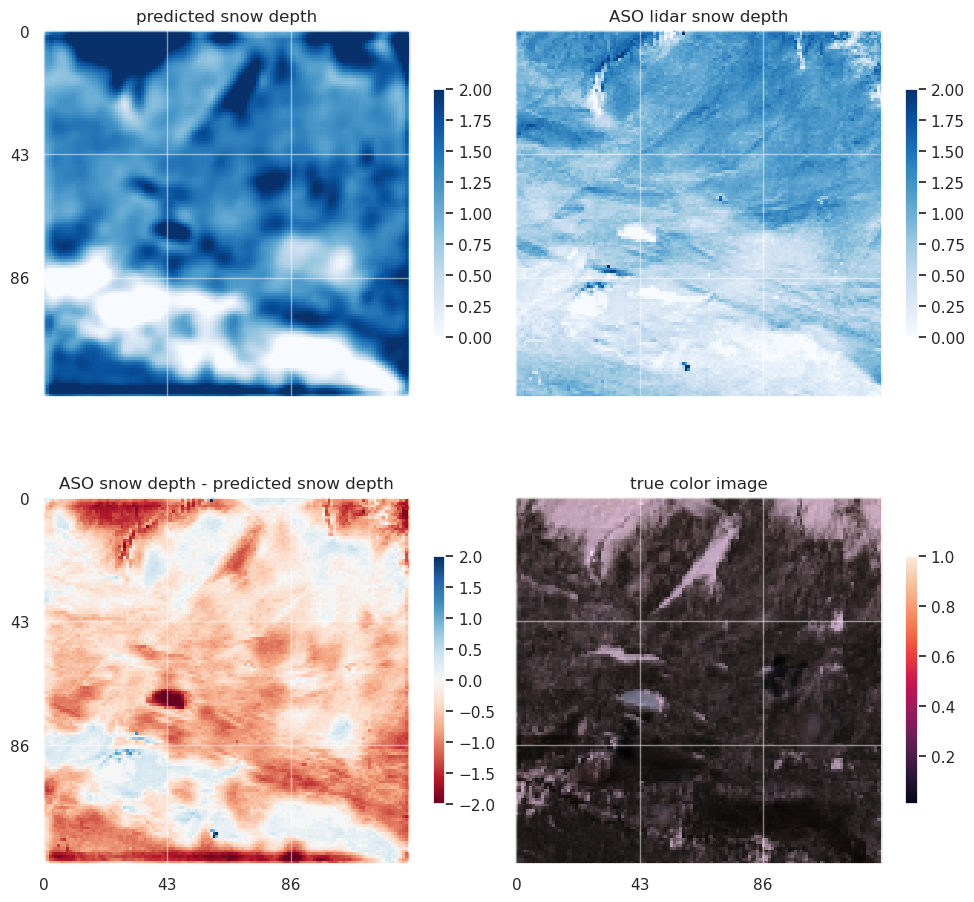

In [11]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = crunchy_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break